<a>
    <div style="margin: 10px;">
        <p align="center">
            <img width="80%" align="center" style="margin-right: 140px;" src="./images/logo.png"/>           
        </p>
    </div>
</a>

<a>
    <div style="margin: 10px;">
        <p align="center">
            <img width="80%" align="center" style="margin-right: 140px;" src="./images/review-emoji.png"/>           
        </p>
    </div>
</a>

# Summary

1. [Exploratory Data Analysis](#eda)<br>

2. [Feature Engineering](#featureengineering)<br>
    2.1. [Term Frequency-Inverse Document Frequency (TF-IDF)](#tfidf)<br>
    
3. [Training model](#model)<br>
    
4. [Results](#results)<br>

5. [Saving model](#saving)<br>

# 1. Exploratory Data Analysis <a name="eda"></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

The review file is contained in *yelp_academic_dataset_review.json*, Identifying the data type of each column can reduce memory usage and this information is contained in the dataset documentation: https://www.yelp.com/dataset/documentation/main

In [14]:
!du -sh yelp_academic_dataset_review.json

5,9G	yelp_academic_dataset_review.json


The dataset is quiet large so a good approach is to read it by chunks

In [15]:
chunk_size = 500000
review = pd.read_json('yelp_academic_dataset_review.json',
                      lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=chunk_size)

In [16]:
chunk_list = []
for chunk_review in review:
    
    # Drop columns that aren't needed
    chunk_review = chunk_review.drop(['review_id','useful','funny',
                                      'cool', 'date', 'business_id',
                                      'user_id'], axis=1)
    chunk_list.append(chunk_review)

# Concatenate all data back to one dataframe
review_df = pd.concat(chunk_list, ignore_index=True, axis=0)

In [20]:
review_df.head(5)

,stars,text
0,2,"As someone who has worked with many museums, I..."
1,1,I am actually horrified this place is still in...
2,5,I love Deagan's. I do. I really do. The atmosp...
3,1,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,4,"Oh happy day, finally have a Canes near my cas..."


In [21]:
# Checking for missing values
review_df.isnull().any()

stars    False
text     False
dtype: bool

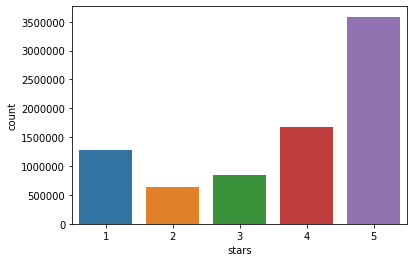

In [22]:
# Checking the scores distribution
sns.countplot(review_df.stars);

As we can see, the dataset in unbalanced, having more high scores than low score, so to avoid creating a biased model, it's good to balance this dataset, and an approach is to round down all classes to the one with lowest distribution, which is the score of 2

In [26]:
# Number of reviews with 2 stars
number_of_reviews_2_stars = review_df[review_df.stars==2].shape[0]
number_of_reviews_2_stars

635072

# 2. Feature Engineering <a name="featureengineering"></a>

In [27]:
from sklearn.utils import resample

# Separate majority and minority classes
review_df_1_star = review_df[review_df.stars==1]
review_df_2_star = review_df[review_df.stars==2]
review_df_3_star = review_df[review_df.stars==3]
review_df_4_star = review_df[review_df.stars==4]
review_df_5_star = review_df[review_df.stars==5]

# Downsampling classes
review_df_1_star_downsampled = resample(review_df_1_star, 
                                        replace=False,    # sample without replacement
                                        n_samples=number_of_reviews_2_stars, # to match minority class
                                        random_state=123) # reproducible results

review_df_3_star_downsampled = resample(review_df_3_star, 
                                        replace=False,    # sample without replacement
                                        n_samples=number_of_reviews_2_stars, # to match minority class
                                        random_state=123) # reproducible results

review_df_4_star_downsampled = resample(review_df_4_star, 
                                        replace=False,    # sample without replacement
                                        n_samples=number_of_reviews_2_stars, # to match minority class
                                        random_state=123) # reproducible results

review_df_5_star_downsampled = resample(review_df_5_star, 
                                        replace=False,    # sample without replacement
                                        n_samples=number_of_reviews_2_stars, # to match minority class
                                        random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
review_df_balanced = pd.concat([review_df_1_star_downsampled,
                                review_df_2_star,
                                review_df_3_star_downsampled,
                                review_df_4_star_downsampled,
                                review_df_5_star_downsampled])

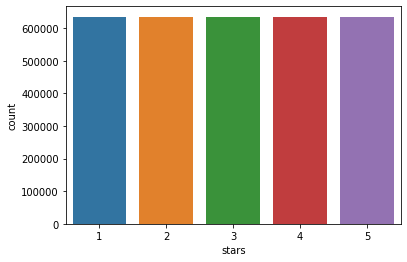

In [28]:
# Checking the scores distribution in balanced dataframe
sns.countplot(review_df_balanced.stars);

In [29]:
review_df_balanced.to_csv('yelp_reviews_text_stars_balanced.csv', index=False)

In [31]:
print(review_df_balanced.shape)
review_df_balanced.head()

(3175360, 2)


,stars,text
5485243,1,"Typically, I love Clothes Mentor. What's bett..."
6326698,1,Horrible! We were in town sightseeing and the...
3637169,1,My boyfriend went here 2 weeks ago with his da...
5315402,1,"If you want to have food missing, not made the..."
2792426,1,Worst experience ever. A bunch of liars and th...


Changing the stars columns, ranging from 1 to 5, to 1, 2 or 3, representing Negative, Neutral and Positive sentiments respectively

In [32]:
# reduce the 5 stars range to 3 sentiments (0 for negative, 1 for neutral and 2 for positive)
review_df_balanced['sentiment'] = review_df_balanced['stars'].apply(
    lambda x: 0 if x < 3 else (1 if x == 3 else 2))

# Dropping stars column
review_df_balanced.drop('stars', axis=1, inplace=True)

## Separating data in train and test with 30% test set and stratification

In [39]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(review_df_balanced,
                               test_size=0.3,
                               stratify=review_df_balanced['sentiment'],
                               random_state = 42)

In [40]:
import string

def text_prep(text):
    '''
    Remove some stop words and abbreviations manually
    '''
    punct = set(string.punctuation)
    
    #clean text
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'ve", " have ", text)    
    text = re.sub(r"\'d", " would ", text)    
    
    #remove non-letters and lower case
    text = re.sub('[^a-z\s]', '', text.lower())
    
    #remove punctuation        
    punc_removed = [char for char in text if char not in punct]
    punc_removed = ''.join(punc_removed)
    
    return [word for word in punc_removed.split()]

# 2.1 Term Frequency-Inverse Document Frequency (TF-IDF)  <a name="tfidf"></a>

TF-IDF is a statistical measure that evaluates how relevant a word is to a document (could be a text column in a pandas dataframe for example), in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. It can be expressed as:


<div align="center"  style="margin: 20px;">    
$\begin{align}
 TFIDF_{i,j} = TF*IDF
\end{align}$ 
where:
</div>



<div align="center"  style="margin: 20px;">    
$\begin{align}
 TF_{i,j} = \frac{number\ of\ times\ term\ i\ is\ on\ document\ j}{total\ number\ of\ terms\ on\ document\ j}
\end{align}$ 
</div>


<div align="center"  style="margin: 20px;">    
$\begin{align}
 IDF_{i} = ln\left(\frac{total\ number\ of\ documents}{number\ of\ document\ containing\ the\ term\ i}\right)
\end{align}$ 
</div>

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

# min_df ignores terms that occur with a frequency lower than 10 documents, and max_df ignores documents that
# occur with a frequency higher than 95% of documents
tfidf_vectorizer = TfidfVectorizer(use_idf=True, analyzer=text_prep, min_df=10, max_df=0.95)
tfidf_vectorizer.fit_transform(train['text'].values)

# Transforming train set with tfidf
train_feature_set = tfidf_vectorizer.transform(train['text'].values)

# Transforming test set with tfidf
test_feature_set = tfidf_vectorizer.transform(test['text'].values)

In [43]:
# Separating labels
y_train = train['sentiment'].values
y_test = test['sentiment'].values

# 3. Training model <a name="model"></a>

In [46]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)

# 4. Results <a name="results"></a>

In [48]:
from sklearn import metrics

print("Accuracy: ", metrics.accuracy_score(y_test,y_pred))
print("F1: ", metrics.f1_score(y_test, y_pred, average=None))

Accuracy:  0.7933483657496053
F1:  [0.85235351 0.46635105 0.86253814]


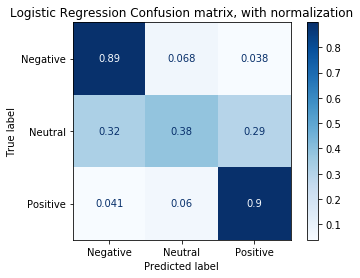

In [49]:
disp = metrics.plot_confusion_matrix(lr, test_feature_set, y_test,
                                     display_labels=['Negative', 'Neutral', 'Positive'],
                                     cmap=plt.cm.Blues,
                                     normalize='true')
disp.ax_.set_title('Logistic Regression Confusion matrix, with normalization');

As the confusion matrix shows, the model is classifying negative and positive sentiments with a good accuracy of ~90%, while having a low accuracy for neutral sentiments, this could be from the fact that these classes were created by attributing a range out of 5 stars for each class (1 and 2 for negative, 3 for neutral, 4 and 5 for positive).

Another possible implementation would be to use **TextBlob**, which classifies a sentence in a range from -1 to 1, so we could attribute from -1 to -0.3 to negative sentiment, from -0.3 to +0.3 to neutral sentiment and from +0.3 to 1 to positive sentiment. 

In [51]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)

top_10_negative = [list(tfidf_vectorizer.vocabulary_.keys())[list(
    tfidf_vectorizer.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1, -11, -1)]]

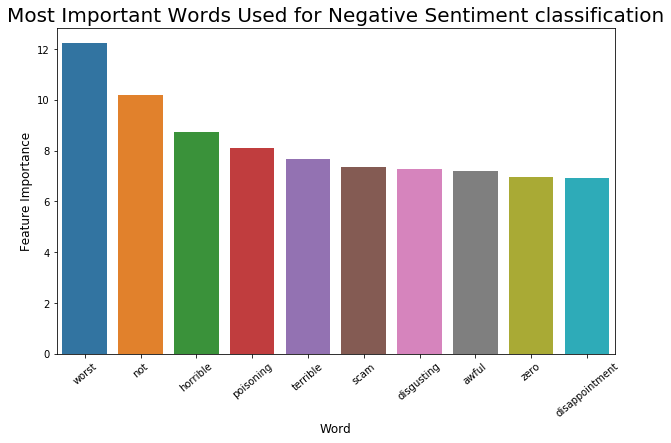

In [52]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_negative, feature_importance[sorted_idx[range(-1, -11, -1)]])
plt.title("Most Important Words Used for Negative Sentiment classification", fontsize=20)

x_locs, x_labels = plt.xticks()
plt.setp(x_labels, rotation=40)
plt.ylabel('Feature Importance', fontsize=12)
plt.xlabel('Word', fontsize=12);

In [53]:
top_10_positive = [list(tfidf_vectorizer.vocabulary_.keys())[list(
    tfidf_vectorizer.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]

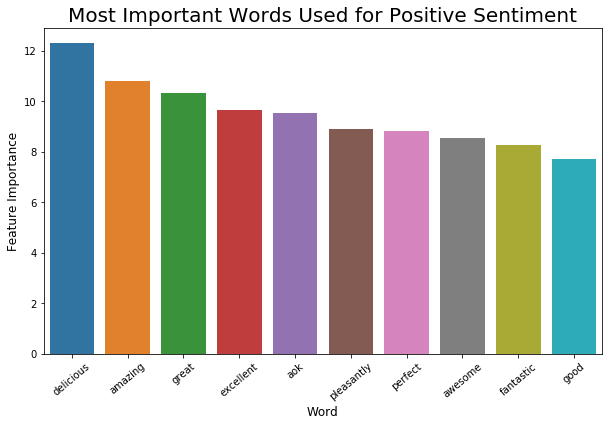

In [54]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(top_10_positive, feature_importance[sorted_idx[:10]]*-1)
plt.title("Most Important Words Used for Positive Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

# 5. Saving model <a name="saving"></a>

In [55]:
import pickle
import joblib

# Saving tfidf_vectorizer and logistic regression model
joblib.dump([tfidf_vectorizer, lr], 'sentiment_classifier_model.pkl')

['sentiment_classifier_model.pkl']

In [59]:
test_review = cv.transform(["I did not enjoy the food or the service"])
np.argmax(lr.predict_proba(test_review))

0

In [58]:
test_review = cv.transform(["This place was great!"])
np.argmax(lr.predict_proba(test_review))

2